In [2]:
import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
import torchvision.transforms as tt
# import albumentations as A
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
# Set device 
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cpu'

In [4]:
# Set ranodm seed 
np.random.seed(1)
torch.manual_seed(1)

In [5]:
ROOT_PATH = 'archive 2/kaggle_3m/'

mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})


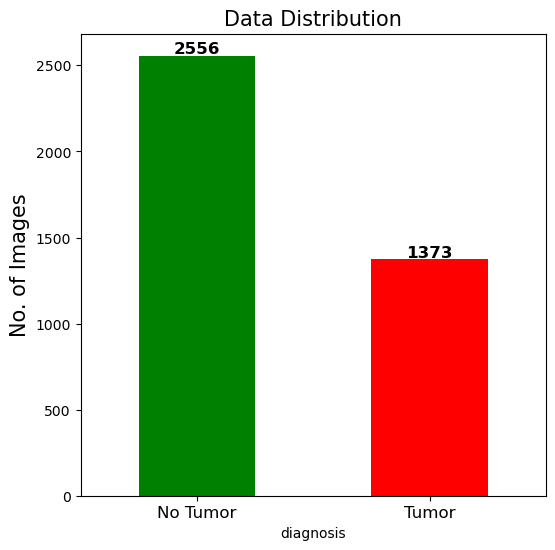

In [33]:
ax = files_df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(6,6), color=['green', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('No. of Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(files_df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=12)

In [34]:
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


In [35]:
train_df

,image_path,mask_path,diagnosis
0,archive 2/kaggle_3m/TCGA_HT_A61B_19991127/TCGA...,archive 2/kaggle_3m/TCGA_HT_A61B_19991127/TCGA...,0
1,archive 2/kaggle_3m/TCGA_CS_6669_20020102/TCGA...,archive 2/kaggle_3m/TCGA_CS_6669_20020102/TCGA...,0
2,archive 2/kaggle_3m/TCGA_CS_6666_20011109/TCGA...,archive 2/kaggle_3m/TCGA_CS_6666_20011109/TCGA...,1
3,archive 2/kaggle_3m/TCGA_FG_6689_20020326/TCGA...,archive 2/kaggle_3m/TCGA_FG_6689_20020326/TCGA...,0
4,archive 2/kaggle_3m/TCGA_DU_6400_19830518/TCGA...,archive 2/kaggle_3m/TCGA_DU_6400_19830518/TCGA...,0
...,...,...,...
3000,archive 2/kaggle_3m/TCGA_FG_A60K_20040224/TCGA...,archive 2/kaggle_3m/TCGA_FG_A60K_20040224/TCGA...,0
3001,archive 2/kaggle_3m/TCGA_DU_7010_19860307/TCGA...,archive 2/kaggle_3m/TCGA_DU_7010_19860307/TCGA...,0
3002,archive 2/kaggle_3m/TCGA_HT_A61A_20000127/TCGA...,archive 2/kaggle_3m/TCGA_HT_A61A_20000127/TCGA...,1
3003,archive 2/kaggle_3m/TCGA_HT_7882_19970125/TCGA...,archive 2/kaggle_3m/TCGA_HT_7882_19970125/TCGA...,0


(-0.5, 1279.5, 255.5, -0.5)

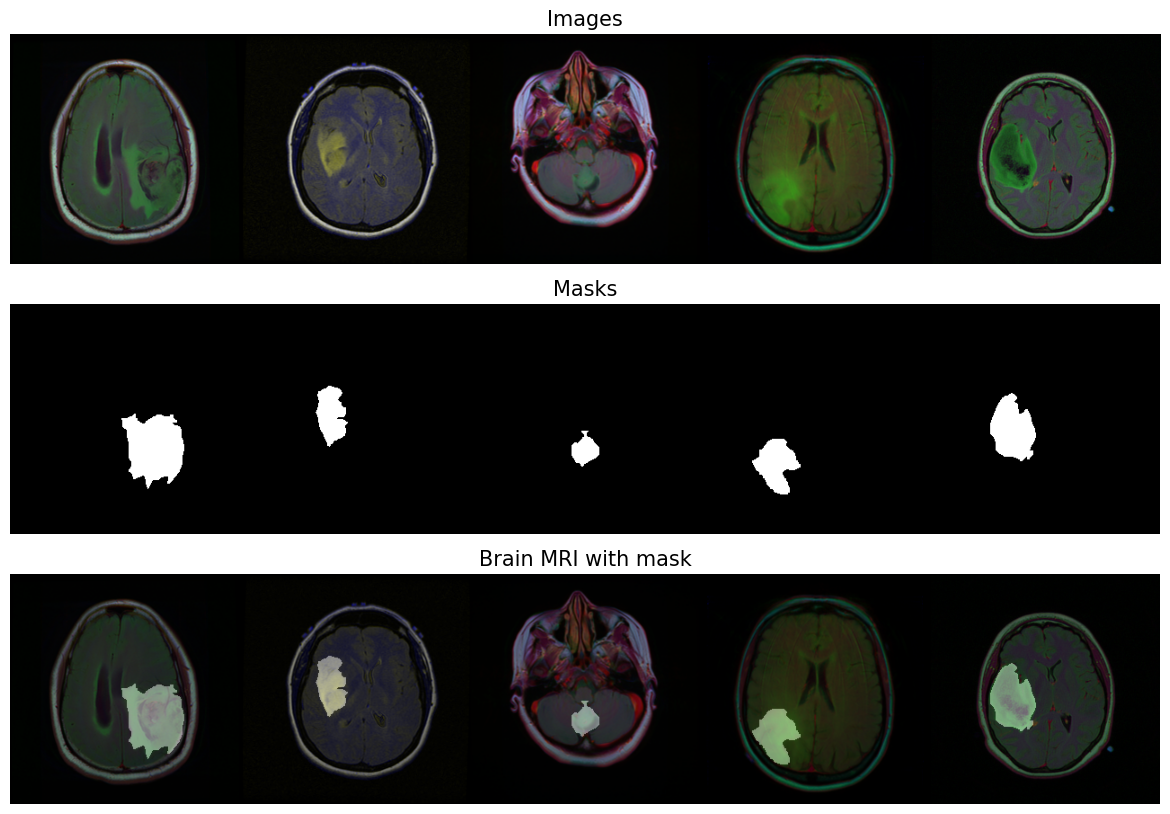

In [36]:
images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(15,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')